In [48]:
import torch
from torchvision import datasets, transforms
import torchvision
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [49]:
torch.manual_seed(42)

In [50]:
train_dataset=datasets.CIFAR10(root='./data',download=True, train= True)
test_dataset=datasets.CIFAR10(root='./data',download=True, train= False)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
train_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transforms.ToTensor())

# Check the shape of the first image in the dataset to also confirm the number of channels and image size
train_dataset[0][0].shape

Files already downloaded and verified


torch.Size([3, 32, 32])

In [60]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((32, 32), scale=(0.75, 1))])

val_transforms = transforms.Compose([transforms.ToTensor()])

In [61]:
train_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transforms)
val_dataset = datasets.CIFAR10(root='./data', download=True, train=False, transform=val_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [62]:
# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, )
print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 50000 train images and 10000 val images


In [63]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        # Our images are RGB, so input channels = 3. We'll apply 32 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # A second convolutional layer takes 32 input channels, and generates 64 outputs
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # We'll apply max pooling with a kernel size of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # A third convolutional layer takes 64 input channels, and generates 128 outputs
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # A fourth convolutional layer takes 128 input channels, and generates 128 outputs
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # A fifth convolutional layer takes 128 input channels, and generates 256 outputs
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

         # We'll apply another max pooling with a kernel size of 2
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        self.fc = nn.Linear(in_features=4 * 4 * 256, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=512)
        self.fc5 = nn.Linear(in_features=512, out_features=256)
        self.fc6 = nn.Linear(in_features=256, out_features=128)
        self.fc7 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = self.drop(x)

        # Flatten
        x = x.view(-1, 4 * 4 * 256)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        # Return log_softmax tensor
        return F.log_softmax(x, dim=1)
# Instantiate the model
model = Net()
print("CNN model class defined!")

CNN model class defined!


In [64]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [65]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print(f'Validation set: Average loss: {avg_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)')
   # return average loss for the epoch
    return avg_loss

In [66]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=10).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over  epochs
epochs = 30
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set:0/50000 (0.0 Loss:2.3020272254943848)
Training set:640/50000 (1.278772378516624 Loss:2.2511985301971436)
Training set:1280/50000 (2.557544757033248 Loss:2.185365915298462)
Training set:1920/50000 (3.836317135549872 Loss:1.9921156167984009)
Training set:2560/50000 (5.115089514066496 Loss:2.0177829265594482)
Training set:3200/50000 (6.3938618925831205 Loss:2.128391742706299)
Training set:3840/50000 (7.672634271099744 Loss:2.0279667377471924)
Training set:4480/50000 (8.951406649616368 Loss:1.9136775732040405)
Training set:5120/50000 (10.230179028132993 Loss:1.992175817489624)
Training set:5760/50000 (11.508951406649617 Loss:2.011855363845825)
Training set:6400/50000 (12.787723785166241 Loss:1.9492638111114502)
Training set:7040/50000 (14.066496163682864 Loss:2.022703170776367)
Training set:7680/50000 (15.345268542199488 Loss:2.1011548042297363)
Training set:8320/50000 (16.624040920716112 Loss:1.8113436698913574)
Training set:8960/50000 (17.9028132992

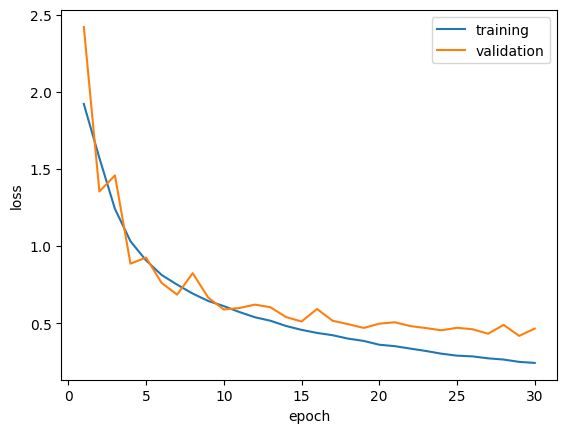

In [67]:
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()